In [15]:
import os
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# helper functions

def series_append(series, list, keys):
    for i in range(64):
        series[keys[i]].append(float(list[i]))
    return series

def load_series(filename):
    with open(filename, 'r') as csv_in:
        csv_file = list(csv.reader(csv_in))
        series = {}
        keys = csv_file[0]
        for key in keys: series[key] = []
        for i in range(2, len(csv_file), 2):
            series = series_append(series, csv_file[i], keys)
        return [series, int((len(csv_file) - 2) / 2)]

def unroll(series):
    l = []
    for key in series:
        if (key[-1] == 'v' or key[-1] == 'z'): continue
        l += series[key]
    return l

def add_shift(series):
    scale_factor = 0.2
    for key in series:
        if (key[-1] != 'z' and key[-1] != 'v'):
            rand_num = np.random.rand() * scale_factor - (scale_factor / 2)
            series[key] = [x + rand_num for x in series[key]]
    return series

def add_noise(series):
    scale_factor = 0.05
    for key in series:
        if (key[-1] != 'z' and key[-1] != 'v'):
            rand_num = np.random.rand() * scale_factor - (scale_factor / 2)
            series[key] = [x + (np.random.rand() * scale_factor - (scale_factor / 2)) for x in series[key]]
    return series

def rand_augment(series):
    series = add_shift(series)
    series = add_noise(series)
    return series

def E3(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= 3.5):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E2(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= 2.5):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E1(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= 1.5):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E0(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= 0.5):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

In [52]:
# defining contrastive loss function

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1000000000.0):
            super(ContrastiveLoss, self).__init__()
            self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss

In [53]:
# defining siamese network

input_size = 224
fc_1 = 512
fc_2 = 384
fc_3 = 256
fc_4 = 192
fc_5 = 128
fc_6 = 64
output_size = 32
learning_rate = 0.01

class SiameseNetwork(nn.Module):
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                m.bias.data.fill_(1.0)
            
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, fc_1)
        self.fc2 = nn.Linear(fc_1, fc_2)
        self.fc3 = nn.Linear(fc_2, fc_3)
        self.fc4 = nn.Linear(fc_3, fc_4)
        self.fc5 = nn.Linear(fc_4, fc_5)
        self.fc6 = nn.Linear(fc_5, fc_6)
        self.fc7 = nn.Linear(fc_6, output_size)

    def forward(self, x1):
        x1 = F.relu(self.fc1(x1))
        x1 = F.relu(self.fc2(x1))
        x1 = F.relu(self.fc3(x1))
        x1 = F.relu(self.fc4(x1))
        x1 = F.relu(self.fc5(x1))
        x1 = F.relu(self.fc6(x1))
        x1 = F.relu(self.fc7(x1))

        return x1

model = SiameseNetwork()
loss_function = ContrastiveLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

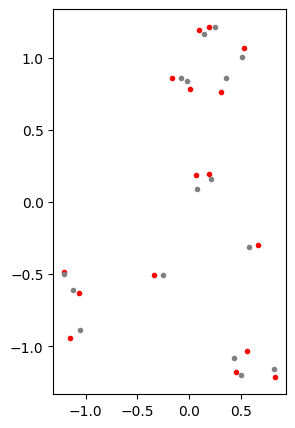

In [19]:
# testing augmentation strength

series, num_frames = load_series("..\\time_series\\Time_normalized_stages\\4_final\\WS-O1-F0-B5-S4-L0-L-0102.csv")

fig, ax = plt.subplots(1, figsize=(3, 5))

raw_x = []
raw_y = []

for key in series:
    if (key[-1] == 'x'):
        raw_x.append(series[key][2])
    elif (key[-1] == 'y'):
        raw_y.append(series[key][2])

series = rand_augment(series)

aug_x = []
aug_y = []

for key in series:
    if (key[-1] == 'x'):
        aug_x.append(series[key][2])
    elif (key[-1] == 'y'):
        aug_y.append(series[key][2])

ax.plot(raw_x, raw_y, '.', c='r')
ax.plot(aug_x, aug_y, '.', color='gray')

In [41]:
# loading dataset

dir = '..\\time_series\Time_normalized_stages\\4_final\\'
train_files = os.listdir(dir)

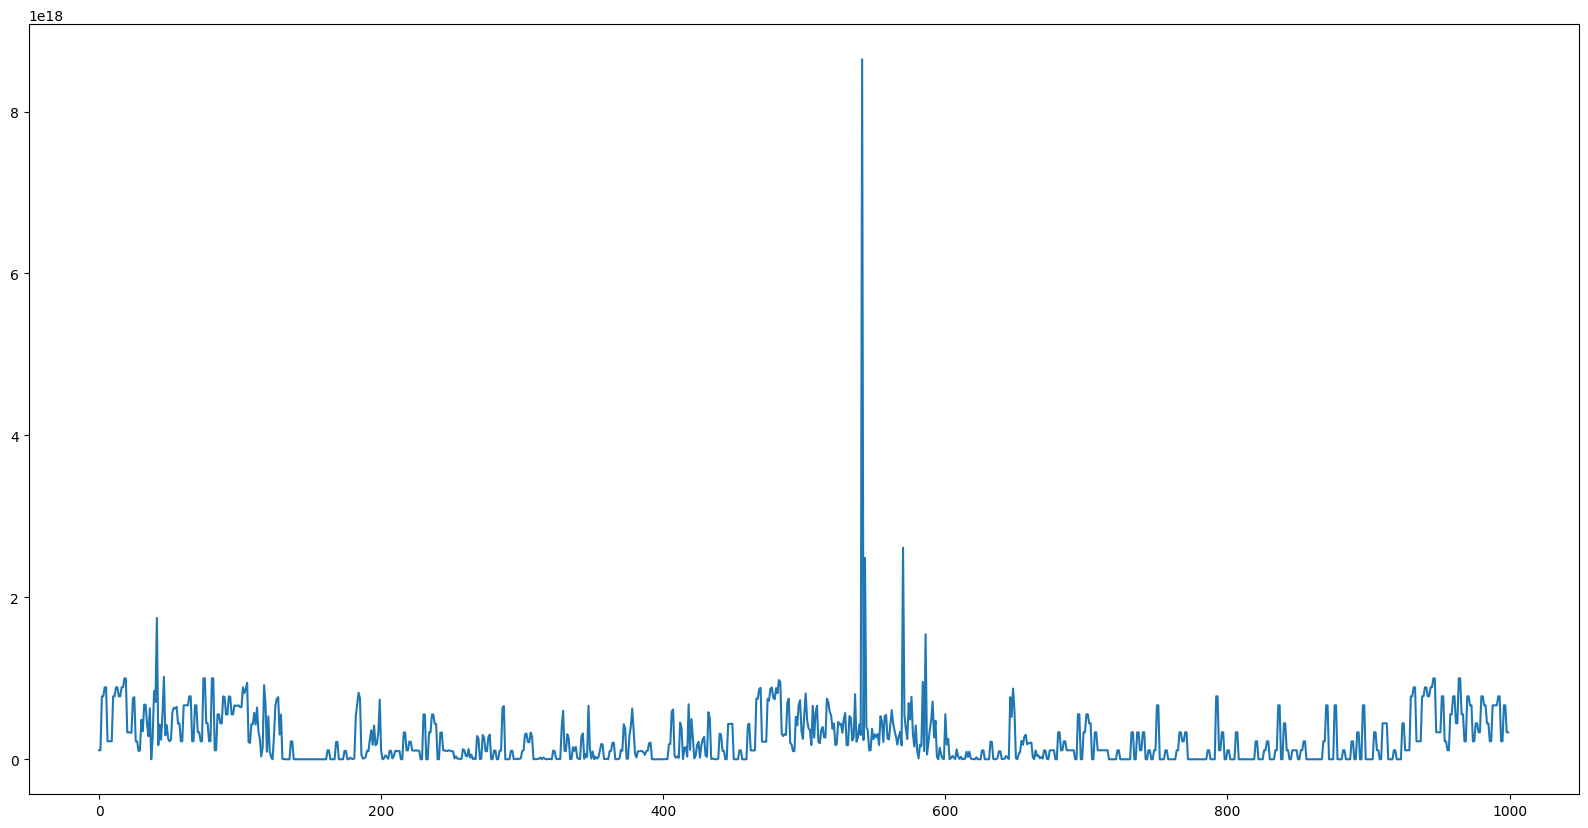

In [54]:
num_epochs = 1000

losses = []
model.apply(model._init_weights)

for epoch in range(num_epochs):
    train_index = epoch % len(train_files)
    label = (float)((int)(train_files[train_index][16]) / 9)
    x, n = load_series(dir + train_files[train_index])
    x1 = torch.tensor(unroll(rand_augment(x)))
    x2 = torch.tensor(unroll(rand_augment(x)))

    enc1 = model(x1)
    enc2 = model(x2)

    contrastive_loss = loss_function(enc1, enc2, label)
    losses.append(contrastive_loss.item())

    contrastive_loss.backward()
    optimizer.step()
    
fig, ax = plt.subplots(1, figsize=(20, 10))
plt.plot(losses)

In [55]:
# load data
with open("..\\test_examples.txt") as t:
    test_files = t.readlines()

with open("..\\training_examples.txt") as t:
    training_examples = t.readlines()

dir = '..\\time_series\\Time_normalized_stages\\4_final\\'
files = os.listdir(dir)

test_examples = []
test_labels = []

for file in test_files:
    series, num_frames = load_series(dir + file[:-1])
    test_examples.append(unroll(series))
    test_labels.append(int(file[4]))

l_0 = []
l_1 = []
l_2 = []
l_3 = []
l_4 = []
l_5 = []
l_6 = []
l_7 = []
l_8 = []

for file in training_examples:
    series, num_frames = load_series(dir + file[:-1])
    label = int(file[4])
    if (label == 0):
        l_0.append(unroll(series))
    elif (label == 1):
        l_1.append(unroll(series))
    elif (label == 2):
        l_2.append(unroll(series))
    elif (label == 3):
        l_3.append(unroll(series))
    elif (label == 4):
        l_4.append(unroll(series))
    elif (label == 5):
        l_5.append(unroll(series))
    elif (label == 6):
        l_6.append(unroll(series))
    elif (label == 7):
        l_7.append(unroll(series))
    elif (label == 8):
        l_8.append(unroll(series))

l_0 = torch.tensor(l_0)
l_1 = torch.tensor(l_1)
l_2 = torch.tensor(l_2)
l_3 = torch.tensor(l_3)
l_4 = torch.tensor(l_4)
l_5 = torch.tensor(l_5)
l_6 = torch.tensor(l_6)
l_7 = torch.tensor(l_7)
l_8 = torch.tensor(l_8)
test_examples = torch.tensor(test_examples)

print(l_0.size())
print(l_1.size())
print(l_2.size())
print(l_3.size())
print(l_4.size())
print(l_5.size())
print(l_6.size())
print(l_7.size())
print(l_8.size())
print(test_examples.size())

X_train = [l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7, l_8]
print(type(X_train[0]))

torch.Size([44, 224])
torch.Size([94, 224])
torch.Size([78, 224])
torch.Size([54, 224])
torch.Size([34, 224])
torch.Size([25, 224])
torch.Size([16, 224])
torch.Size([18, 224])
torch.Size([8, 224])
torch.Size([93, 224])
<class 'torch.Tensor'>


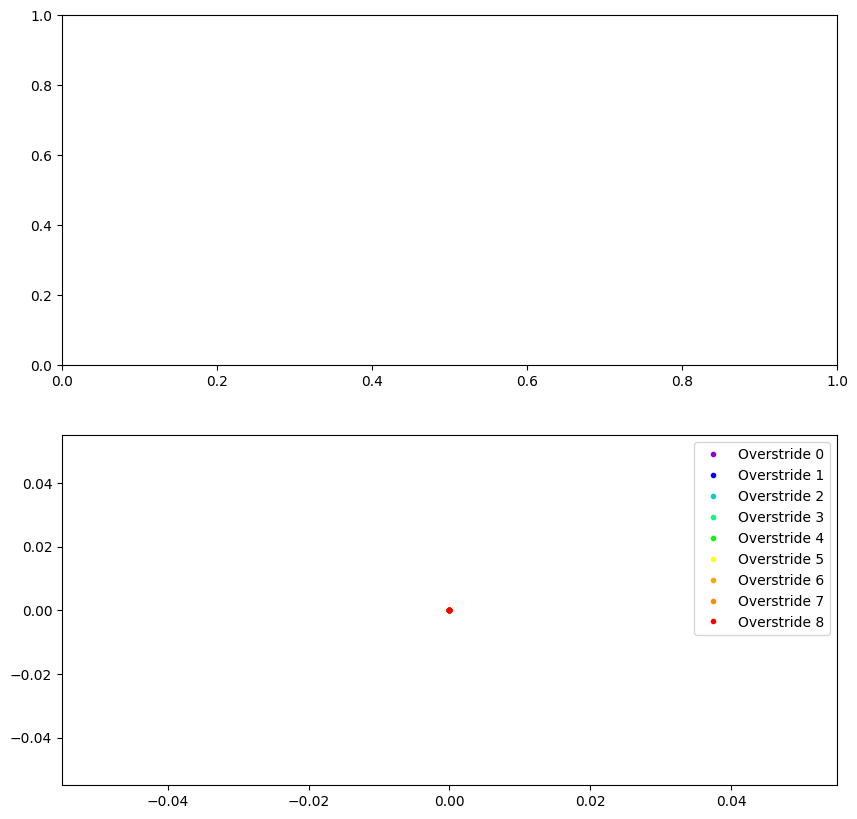

In [56]:
# examining 2d encodings


l0x = []
l0y = []
l1x = []
l1y = []
l2x = []
l2y = []
l3x = []
l3y = []
l4x = []
l4y = []
l5x = []
l5y = []
l6x = []
l6y = []
l7x = []
l7y = []
l8x = []
l8y = []

for example in X_train[0]:
    enc = model(example).tolist()
    l0x.append(enc[0])
    l0y.append(enc[1])

for example in X_train[1]:
    enc = model(example).tolist()
    l1x.append(enc[0])
    l1y.append(enc[1])

for example in X_train[2]:
    enc = model(example).tolist()
    l2x.append(enc[0])
    l2y.append(enc[1])

for example in X_train[3]:
    enc = model(example).tolist()
    l3x.append(enc[0])
    l3y.append(enc[1])

for example in X_train[4]:
    enc = model(example).tolist()
    l4x.append(enc[0])
    l4y.append(enc[1])

for example in X_train[5]:
    enc = model(example).tolist()
    l5x.append(enc[0])
    l5y.append(enc[1])

for example in X_train[6]:
    enc = model(example).tolist()
    l6x.append(enc[0])
    l6y.append(enc[1])

for example in X_train[7]:
    enc = model(example).tolist()
    l7x.append(enc[0])
    l7y.append(enc[1])

for example in X_train[8]:
    enc = model(example).tolist()
    l8x.append(enc[0])
    l8y.append(enc[1])

fig, ax = plt.subplots(2, figsize=(10, 10))

ax[1].plot(l0x, l0y, '.', c='darkviolet', label='Overstride 0')
ax[1].plot(l1x, l1y, '.', c='blue', label='Overstride 1')
ax[1].plot(l2x, l2y, '.', c='darkturquoise', label='Overstride 2')
ax[1].plot(l3x, l3y, '.', c='springgreen', label='Overstride 3')
ax[1].plot(l4x, l4y, '.', c='lime', label='Overstride 4')
ax[1].plot(l5x, l5y, '.', c='yellow', label='Overstride 5')
ax[1].plot(l6x, l6y, '.', c='orange', label='Overstride 6')
ax[1].plot(l7x, l7y, '.', c='darkorange', label='Overstride 7')
ax[1].plot(l8x, l8y, '.', c='red', label='Overstride 8')

ax[1].legend()